In [1]:
import h5py    
import numpy as np 
import matplotlib.pyplot as plt
import pyjet
from pyjet import cluster, DTYPE_PTEPM, DTYPE_EP
import pandas as pd
import json
from functools import wraps 
from timeit import default_timer as timer

import unittest
import os
from numpy import exp, log
from functools import partial
from scipy.special import gamma, gammaln
from scipy.cluster.hierarchy import dendrogram, fcluster, leaves_list, to_tree
#from sklearn.datasets import make_moons
import pandas as pd
from time import time
import sys
import itertools
from scipy import linalg
from collections import Counter
import time
import pickle



In [2]:
def bhc_inclusive_jets(event, family, sigma, alpha, r , alpha_l, beta_l, bal, position_only, DP_mod, cutoff, ptmin):
    """Return a matrix in the format of linkage matrix for dendrogram
        @dat: N records of data with k columns
        @family: function to specify distribution for data. {"multivariate", "bernoulli"}
        @alpha: hyperparameter for the prior
        @r: scaling factor on the prior precision of the mean
    """
    
    dat=np.array([[e[1],e[2]] for e in event])
    mdata_p=np.array([e[0] for e in event])
    mom_tot=sum(mdata_p)

    
    N, k = dat.shape
    la = log(alpha)
    
    if family == "multivariate":
        m = np.mean(dat, axis=0).reshape(k, 1)
        S = np.cov(dat.T) # precision?
        def mlfunc(X):
            return gauss(X, m, S, sigma)

    if family == "multivariate-inverse_wishart":
        m = np.mean(dat, axis=0).reshape(k, 1)
        S = np.cov(dat.T) # precision?
        def mlfunc(X):
            return niw(X, m, S, r)
        
    elif family == "multivariate-inverse_gamma":
        m = np.mean(dat, axis=0).reshape(k, 1)
        s = np.linalg.det(np.cov(dat.T)) # precision?
        def mlfunc(X):
            return nig(X, m, s, r)
        
    # leaf nodes
    SS = list(range(N))
    x0 = []; d0 = [la] * N
    ml = []
    for l in range(N):
        x0.append((l,))
        ml.append(mlfunc(dat[l,].reshape(1,k)))

    # paired base cases
    t = 0; PP = []
    c1 = []; c2 = []
    x = []; mom = []; d = []
    lp1 = []; lp2 = []; lodds = [];loddsp=[]; loddst=[];
    for i in range(N-1):
        for j in range(i+1, N):
            c1.append(i); c2.append(j)
            x.append(x0[i]+x0[j])
            mom.append(sum(mdata_p[x[t][i]] for i in range(len(x[t]))))
            if DP_mod==1:
                gamma_arg=mom[t]/mom_tot
            else:
                gamma_arg=len(x[t])
            u = la + gammaln(gamma_arg)
            v = d0[i] + d0[j]
            d.append((u + log(1 + exp(v - u))))
            lp1.append(mlfunc(dat[x[t],:]) + la + gammaln(gamma_arg) - d[t])
            lp2.append(ml[i] + ml[j] + d0[i] + d0[j] - d[t])
            lodds.append(lp1[t] - lp2[t])
            lomax_val=-lomax(np.take(mdata_p,list(x[t])),alpha_l,beta_l)
            loddsp.append(lomax_val)
            loddst.append(lp1[t] - lp2[t] +bal*lomax_val)
            PP.append(t); t = t + 1
            
    # build tree, Z = [leaf1, leaf2, weight, #leaves]
    p = 0
    Z = []

    while(1):
        if position_only == 1:
            idx = lodds.index(max([lodds[y] for y in PP]))
        else:
            idx = loddst.index(max([loddst[y] for y in PP]))
        if not (idx in PP):
            idx = PP[0]
        Z.append([c1[idx], c2[idx], 1/lodds[idx], len(x[idx])])
        
        x0.append(x[idx]); d0.append(d[idx]); ml.append(lp1[idx] + log(1+exp(lp2[idx] - lp1[idx])))
        rm = set(Z[p][:2])
        SS = [y for y in SS if y not in rm]
        if len(SS) == 0:
            break

        for q in SS:
            c1.append(N+p); c2.append(q)
            x.append(x0[N+p] + x0[q])
            mom.append(sum(mdata_p[x[t][i]] for i in range(len(x[t]))))
            if DP_mod==1:
                gamma_arg=mom[t]/mom_tot
            else:
                gamma_arg=len(x[t])
            u = la + gammaln(gamma_arg)
            v = d0[N+p] + d0[q]
            d.append((u + log(1 + exp(v - u))))
            lp1.append(mlfunc(dat[x[t],:]) + la + gammaln(gamma_arg) - d[t])
            lp2.append(ml[N+p] + ml[q] + d0[N+p] + d0[q] - d[t])
            lodds.append(lp1[t] - lp2[t])
            lomax_val=-lomax(np.take(mdata_p,list(x[t])),alpha_l,beta_l)
            loddsp.append(lomax_val)
            loddst.append(lp1[t] - lp2[t] +bal*lomax_val)
            
            PP.append(t); t = t + 1

        PP = [y for y in PP if c1[y] not in rm and c2[y] not in rm]
        SS.append(N + p); p = p + 1

    Z_ = weighted(Z, N)
    #clusters = fcluster(Z_, t=cutoff, criterion='distance')
    clusters = fcluster(Z_, t=-1/np.log(cutoff), criterion='distance') 

    Bayesian_jets={}
    px={}; py={}; pz={}; e={}
    
    for i,c in enumerate(clusters):
        if c not in list(Bayesian_jets.keys()):
            Bayesian_jets[c]=[]
            px[c]=0
            py[c]=0
            pz[c]=0
            e[c] =0
            
        Bayesian_jets[c].append(event[i])  
        
        px[c] += event[i][0]*np.cos(event[i][2])
        py[c] += event[i][0]*np.sin(event[i][2])
        pz[c] += event[i][0]*np.sinh(event[i][1])
        e[c]  += np.sqrt((event[i][0]*np.cos(event[i][2]))**2 + 
                         (event[i][0]*np.sin(event[i][2]))**2 + 
                         (event[i][0]*np.sinh(event[i][1]))**2 + 
                         (event[i][3])**2
                         )
    for j in list(Bayesian_jets.keys()):
        pt = np.sqrt(px[j]**2 + py[j]**2)
        if pt < ptmin:
            Bayesian_jets.pop(j, None)
            
    return Bayesian_jets


def weighted(Z, N):
    mw = max([y[2] for y in Z])
    for i in range(len(Z)):
        if Z[i][2] < 0:
            Z[i][2] = 2 * mw
        if Z[i][0] > (N - 1):
            Z[i][2] += Z[Z[i][0] - N][2]
        if Z[i][1] > (N - 1):
            Z[i][2] += Z[Z[i][1] - N][2]
    return Z

def gauss(X, m, S, sigma):
    """Return marginal likelihood for multivariate normal data using the conjugate prior distribution normal-inverse-Wishart
       @X: N records of data with k columns
       @m: prior on the mean, k * 1
       @S: prior on the covariance, k * k
       @sigma: prior on the covariance
    """
    N, k = X.shape
    
    mean = np.mean(X, axis=0).reshape(k, 1)
    
    logml = - N * np.log(2*np.pi)-N*np.log(sigma) -(N*np.linalg.det(S)+N*(mean.T@mean-mean.T@m-m.T@mean+m.T@m))/(2*sigma**2)
    
    return float(logml)

def scale_matrix(X, N, k, r, m, S):
    """Return scale matrix for the inverse-Wishart distribution on Sigma.
        @X: N records of data with k columns
        @m: prior on the mean, k * 1
        @S: prior on the covariance, k * k
    """

    xsum = np.sum(X, axis = 0).reshape(k,1) # column sum
    t1 = X.T @ X
    t2 = r * N / (N + r) * (m @ m.T)
    t3 = 1/(N+r) * (xsum @ xsum.T)
    t4 = (r / (N + r)) * (m @ xsum.T + xsum @ m.T)

    Sprime = S + t1 + t2 - t3 - t4

    return Sprime


def niw(X, m, S, r):
    """Return marginal likelihood for multivariate normal data using the conjugate prior distribution normal-inverse-Wishart
       @X: N records of data with k columns
       @m: prior on the mean, k * 1
       @S: prior on the covariance, k * k
       @r: scaling factor on the prior precision of the mean
    """

    N, k = X.shape
    v = k
    vprime = v + N
    Sprime = scale_matrix(X, N, k, r, m, S)

    t1 = (2 * np.pi) ** (- N * k / 2)
    t2 = (r / (N + r)) ** (k/2)
    t3 = np.linalg.det(S) ** (v/2)
    t4 = np.linalg.det(Sprime) ** (-vprime/2)
    t5num = np.prod(gamma( (vprime - np.arange(k))/2 ) ) * (2 ** (vprime * k / 2))
    t5den = np.prod(gamma( (v - np.arange(k))/2 ) ) * (2 ** (v * k / 2))

    ml = t1 * t2 * t3 * t4 * (t5num/t5den)

    return np.log(ml)

def nig(X, m, s, r):
    """Return marginal likelihood for multivariate normal data using the conjugate prior distribution normal-inverse-gamma
       @X: N records of data with k columns
       @m: prior on the mean, k * 1
       @r: scaling factor on the prior precision of the mean
    """

    N, k = X.shape
    v = k
    vprime = v + N
    
    S = s * np.identity(k)
    Sprime = scale_matrix(X, N, k, r, m, S)

    t1 = (2 * np.pi) ** (- N * k / 2)
    t2 = (r / (N + r)) ** (k/2)
    t3 = np.linalg.det(S) ** (v/2)
    t4 = np.linalg.det(Sprime) ** (-vprime/2)
    t5num = np.prod(gamma( (vprime - np.arange(k))/2 ) ) * (2 ** (vprime * k / 2))
    t5den = np.prod(gamma( (v - np.arange(k))/2 ) ) * (2 ** (v * k / 2))

    ml = t1 * t2 * t3 * t4 * (t5num/t5den)

    return np.log(ml)

def lomax(X, alpha, beta):
    """Return marginal likelihood for multivariate normal data using the conjugate prior distribution normal-inverse-Wishart
       @X: N records of data with k columns
       @alpha, beta: prior hyperparameters
    """

    N = X.shape[0]
    alpha = alpha + N 
    beta = beta + sum(X)

    pdf = (beta**alpha) * alpha / (beta)**(alpha + 1)

    return np.log(pdf)

In [60]:
## import numpy as np
from pyjet import cluster, DTYPE_PTEPM
from pyjet.testdata import get_event
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import LinearSegmentedColormap

# define eta and phi ranges and number of bins along each axis
eta_min, eta_max = -4,4#-4., 4.
phi_min, phi_max = -np.pi,np.pi #-np.pi, np.pi
extent = eta_min, eta_max, phi_min, phi_max
bins = 15



particles = np.zeros(3, dtype=DTYPE_PTEPM)
particles['pT']  = [400.0, 600.0, 250.0]
particles['eta'] = [2.5, -2.5, 1.5]
particles['phi'] = [2.0, -2.0, 1]
particles['mass'] = [0.0, 0.0, 0.0]

#particles = get_event()

# create regular grid of ghosts
eta_edges = np.linspace(eta_min, eta_max, bins + 1)
phi_edges = np.linspace(phi_min, phi_max, bins + 1)
eta = np.linspace(eta_min, eta_max, bins + 1)[:-1] + (eta_max - eta_min) / (2 * bins)
phi = np.linspace(phi_min, phi_max, bins + 1)[:-1] + (np.pi / bins)
X, Y = np.meshgrid(eta, phi)
ghosts = np.zeros(eta.shape[0] * phi.shape[0], dtype=DTYPE_PTEPM)
ghosts['pT'] = 1e-8
ghosts['eta'] = X.ravel()
ghosts['phi'] = Y.ravel()

# add ghosts to the event
event = np.concatenate([particles, ghosts], axis=0)
len(event)


228

In [61]:
bal=0.5  #  weight of momentum with respect to position
position_only=1 #  1= only positions, 0 = positions and momentum
DP_mod=0
alpha_l =9 
beta_l = 0
alpha =1000
r = 1.4e-5
sigma=2.0
cutoff=0.5

bjets = bhc_inclusive_jets(event,
                          family = "multivariate-inverse_wishart", 
                          sigma=sigma,
                          alpha = alpha, 
                          r = r,
                          alpha_l = alpha_l,
                          beta_l = beta_l,
                          bal = bal,
                          position_only = position_only,
                          DP_mod = DP_mod,
                          cutoff = cutoff,
                          ptmin = 10)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:246: RuntimeWarning: overflow encountered in double_scalars
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:248: RuntimeWarning: divide by zero encountered in log
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:246: RuntimeWarning: invalid value encountered in double_scalars
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:209: RuntimeWarning: divide by zero encountered in log
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in double_scalars
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:204: RuntimeWarning: overflow encountered in double_scalars
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:207: RuntimeWarning: invalid value encountered in double_scalars


In [62]:
bjets

{1: [(400., 2.5, 2., 0.),
  (1.e-08, 2.13333333, 1.67551608, 0.),
  (1.e-08, 2.66666667, 1.67551608, 0.),
  (1.e-08, 3.2, 1.67551608, 0.),
  (1.e-08, 2.13333333, 2.0943951, 0.),
  (1.e-08, 2.66666667, 2.0943951, 0.),
  (1.e-08, 3.2, 2.0943951, 0.),
  (1.e-08, 2.13333333, 2.51327412, 0.),
  (1.e-08, 2.66666667, 2.51327412, 0.),
  (1.e-08, 3.2, 2.51327412, 0.)],
 93: [(600., -2.5, -2., 0.),
  (1.e-08, -3.2, -2.51327412, 0.),
  (1.e-08, -2.66666667, -2.51327412, 0.),
  (1.e-08, -2.13333333, -2.51327412, 0.),
  (1.e-08, -3.2, -2.0943951, 0.),
  (1.e-08, -2.66666667, -2.0943951, 0.),
  (1.e-08, -2.13333333, -2.0943951, 0.),
  (1.e-08, -3.2, -1.67551608, 0.),
  (1.e-08, -2.66666667, -1.67551608, 0.),
  (1.e-08, -2.13333333, -1.67551608, 0.)],
 21: [(250., 1.5, 1., 0.)]}

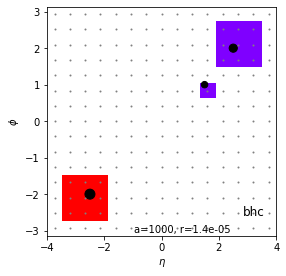

In [63]:
fig = plt.figure(figsize=(4, 4))

# pick a different color for each jet
colors = cm.rainbow(np.linspace(0, 1, len(bjets)))
cmap = LinearSegmentedColormap.from_list('cmap', colors, len(colors))
ax = fig.add_subplot(1,1,1)
area = np.zeros((eta_edges.shape[0] - 1, phi_edges.shape[0] - 1),
                dtype=np.float64)

for i in list(bjets.keys()):
    constit = bjets[i]
    ETA = [c[1] for c in constit]
    PHI = [c[2] for c in constit]
    jetarea, _, _ = np.histogram2d(ETA, PHI,bins=(eta_edges, phi_edges))
    area += (jetarea > 0) * (i + 1)
    
ax.imshow(np.ma.masked_where(area == 0, area).T, cmap=cmap,
              extent=extent, aspect=(eta_max - eta_min) / (phi_max - phi_min),
              interpolation='none', origin='lower')

ax.set_xticks(eta_edges , minor=True)
ax.set_yticks(phi_edges , minor=True)
#ax.grid(which='minor', alpha=1, linestyle='-', lw=0.05, color='k')
    
# overlay original event

ax.scatter(particles['eta'], particles['phi'], s=100 * particles['pT'] / particles['pT'].max(), color='k')
ax.scatter(ghosts['eta'], ghosts['phi'],s=1, color='gray')
    
ax.set_xlim(extent[:2])
ax.set_ylim(extent[2:])
ax.set_ylabel(r'$\phi$')
ax.set_xlabel(r'$\eta$')

ax.text(0.95, 0.075, 'bhc',
    verticalalignment='bottom', horizontalalignment='right',
    transform=ax.transAxes,
    fontsize=12)
ax.text(0.8, 0.05, 'a={}, r={}'.format(alpha,r),
    verticalalignment='top', horizontalalignment='right',
    transform=ax.transAxes,
    fontsize=10)

ax.tick_params(axis='x', which='minor', size=0.0)
ax.tick_params(axis='y', which='minor', size=0.0)

fig.subplots_adjust(hspace=0)
plt.setp([a.get_yticklabels() for a in fig.axes[1:]], visible=False)
fig.tight_layout()
plt.show()
#fig.savefig('Plots/bhc_areas_' + str(alpha) + '_' + str(r)+'.pdf', dpi = 30000)

In [7]:
print(len(bjets))

84


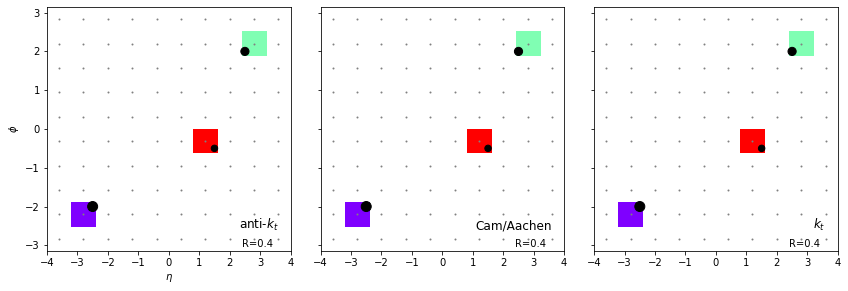

In [8]:
R=0.4

fig = plt.figure(figsize=(12, 4))
ax = None
for p, label in zip((-1, 0, 1), (r'anti-$k_t$', 'Cam/Aachen', '$k_t$')):
    # cluster
    sequence = cluster(event, R=R, p=p)
    jets = sequence.inclusive_jets(ptmin=10)

    # pick a different color for each jet
    colors = cm.rainbow(np.linspace(0, 1, len(jets)))
    cmap = LinearSegmentedColormap.from_list('cmap', colors, len(colors))
    ax = fig.add_subplot(1, 3, p + 2, sharey=ax)
    area = np.zeros((eta_edges.shape[0] - 1, phi_edges.shape[0] - 1),
                    dtype=np.float64)
    
    for ijet, jet in enumerate(jets):
        constit=jet.constituents_array()
        ETA = constit['eta']
        PHI = constit['phi']
        jetarea, _, _ = np.histogram2d(ETA, PHI,bins=(eta_edges, phi_edges))
        area += (jetarea > 0) * (ijet + 1)
        
    # plot all areas
    ax.imshow(np.ma.masked_where(area == 0, area).T, cmap=cmap,
              extent=extent, aspect=(eta_max - eta_min) / (phi_max - phi_min),
              interpolation='none', origin='lower')

    ax.set_xticks(eta_edges , minor=True)
    ax.set_yticks(phi_edges , minor=True)
    #ax.grid(which='both', alpha=1, linestyle='-', lw=0.05, color='k')

    # overlay original event
    
    ax.scatter(particles['eta'], particles['phi'],s=100 * particles['pT'] / particles['pT'].max(), color='k')
    ax.scatter(ghosts['eta'], ghosts['phi'],s=1, color='gray')
    
    ax.set_xlim(extent[:2])
    ax.set_ylim(extent[2:])
    if p == -1:
        ax.set_ylabel(r'$\phi$')
        ax.set_xlabel(r'$\eta$')

    ax.text(0.95, 0.075, label,
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        fontsize=12)
    ax.text(0.8, 0.05, 'R={}'.format(R),
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes,
        fontsize=10)
    
    ax.tick_params(axis='x', which='minor', size=0.0)
    ax.tick_params(axis='y', which='minor', size=0.0)


fig.subplots_adjust(hspace=0)
plt.setp([a.get_yticklabels() for a in fig.axes[1:]], visible=False)
fig.tight_layout()
plt.show()
#fig.savefig('jet_areas.pdf')